In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib_venn import venn2
from scipy import sparse
from sklearn import linear_model
import numpy as np
import operator
import nltk
import math
from scipy.stats import norm

In [30]:
final_data = pd.read_csv('/content/final.csv')
final_data.head()

,ID,Label,Text
0,1,4,Second refugee family leaves small Newfoundlan...
1,2,7,American border patrol agents stopping and boa...
2,3,4,Girlfriend of illegal immigrant accused in Nor...
3,4,5,Why These Students Are Living With Immigrant F...
4,5,8,Haitian asylum seekers crossing Quebec border ...


In [31]:
# divide final_data into training (60%), development (20%) and test (20%)

import os

splits_dir = "splits"
os.makedirs(splits_dir, exist_ok=True)

# Calculate split sizes
total_size = len(final_data)
train_size = int(0.6 * total_size)
dev_size = int(0.2 * total_size)
test_size = total_size - train_size - dev_size

# Shuffle the data randomly
final_data_shuffled = final_data.sample(frac=1, random_state=5)

# Split the data
train_data = final_data_shuffled[:train_size]
dev_data = final_data_shuffled[train_size:train_size + dev_size]
test_data = final_data_shuffled[train_size + dev_size:]


# Save the splits to text files
train_data.to_csv(os.path.join(splits_dir, "train.txt"), index=False, header=None, sep='\t')
dev_data.to_csv(os.path.join(splits_dir, "dev.txt"), index=False, header=None, sep='\t')
test_data.to_csv(os.path.join(splits_dir, "test.txt"), index=False, header=None, sep='\t')


***Majority Class Classifier***

In [32]:
def load_data(filename):
    X = []
    Y = []
    with open(filename, encoding="utf-8") as file:
        for line in file:
            cols = line.strip().split("\t")
            idd = cols[0]
            label = cols[1].strip()
            text = cols[2]

            X.append(text)
            Y.append(label)

    return X, Y


In [33]:
def majority_class(trainY, evalY):
    labelCounts=Counter()
    for label in trainY:
        labelCounts[label]+=1
    majority_class=labelCounts.most_common(1)[0][0]

    correct=0.
    for label in evalY:
        if label == majority_class:
            correct+=1
    return majority_class, correct/len(evalY)
trainingFile = "splits/train.txt"
devFile = "splits/dev.txt"
testFile = "splits/test.txt"

trainX, trainY=load_data(trainingFile)
devX, devY=load_data(devFile)
testX, testY=load_data(testFile)

mc, mc_devAcc=majority_class(trainY, devY)
_, mc_testAcc=majority_class(trainY, testY)

print("Majority class: %s, dev accuracy: %.3f, test accuracy: %.3f" % (mc, mc_devAcc, mc_testAcc))


Majority class: 7, dev accuracy: 0.130, test accuracy: 0.220


In [34]:
## Ranking the frequency of labels
labelCounts = Counter(trainY)

ranked_labels = labelCounts.most_common()

for i, (label, count) in enumerate(ranked_labels):
    print(f"Rank {i+1}: Label {label} with {count} examples")

Rank 1: Label 7 with 76 examples
Rank 2: Label 6 with 62 examples
Rank 3: Label 8 with 53 examples
Rank 4: Label 5 with 36 examples
Rank 5: Label 4 with 21 examples
Rank 6: Label 3 with 19 examples
Rank 7: Label 9 with 11 examples
Rank 8: Label 2 with 8 examples
Rank 9: Label 10 with 7 examples
Rank 10: Label 1 with 4 examples
Rank 11: Label 0 with 3 examples


In [35]:
### Visualizing top words
# Filter
label_7_texts = [text for text, label in zip(trainX, trainY) if label == "7"]
label_4_texts = [text for text, label in zip(trainX, trainY) if label == "4"]

# Tokenize
all_words = []
for text in label_7_texts:
    words = text.lower().split()
    all_words.extend(words)

word_counts = Counter(all_words)

top_words = word_counts.most_common(50)
words = [word for word, count in top_words]
counts = [count for word, count in top_words]

print(top_words)

[('the', 850), ('to', 410), ('of', 392), ('in', 357), ('a', 348), ('and', 316), ('for', 186), ('on', 140), ('that', 138), ('from', 100), ('by', 92), ('with', 82), ('as', 81), ('is', 78), ('at', 77), ('was', 69), ('have', 68), ('has', 66), ('he', 64), ('are', 63), ('said', 63), ('an', 60), ('immigration', 58), ('who', 54), ('it', 52), ('been', 51), ('people', 48), ('trump', 47), ('be', 47), ('border', 44), ('but', 43), ('his', 43), ('were', 42), ('after', 42), ('—', 41), ('they', 41), ('or', 39), ('migrants', 39), ('their', 37), ('more', 35), ('this', 34), ('immigrants', 33), ('new', 33), ('not', 31), ('will', 31), ('president', 30), ('had', 30), ('which', 28), ('s.', 28), ('over', 28)]


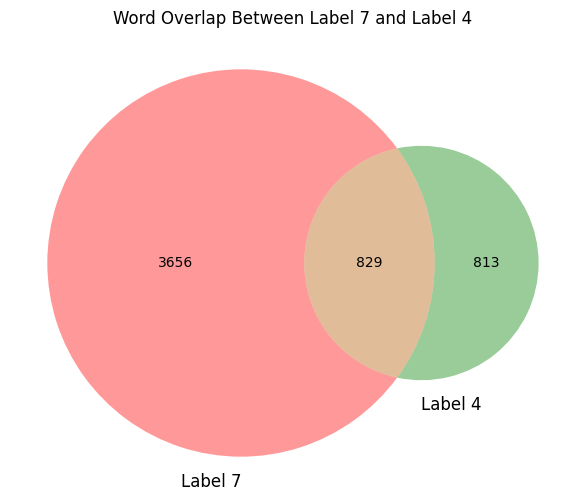

In [36]:
# Get texts for each label
label_7_texts = [text for text, label in zip(trainX, trainY) if label == "7"]
label_4_texts = [text for text, label in zip(trainX, trainY) if label == "4"]

# Tokenize
words_7 = set()
for text in label_7_texts:
    words_7.update(text.lower().split())

words_4 = set()
for text in label_4_texts:
    words_4.update(text.lower().split())

# Plot Venn
plt.figure(figsize=(8,6))
venn2([words_7, words_4], set_labels=('Label 7', 'Label 4'))
plt.title("Word Overlap Between Label 7 and Label 4")
plt.show()


In [37]:
# Shared words between 7 and 4
shared_words = words_7 & words_4
print(list(shared_words)[:30])  # print first 30 shared words

['women', 'army,', 'mostly', 'why', 'officers', '12', 'obama-era', '""', 'secretary', 'increasingly', 'muslim', "'the", 'between', 'committee.', 'mexican', 'health', 'rare', 'week.', 'funding', 'it', 'has', 'year.', 'nearly', 'picture', 'as', 'head', 'some', 'office,', 'saying', 'run']


In [38]:
# Unique to 7
unique_to_7 = words_7 - words_4
print(list(unique_to_7)[:30])

# Unique to 4
unique_to_4 = words_4 - words_7
print(list(unique_to_4)[:30])

['prosecutors’', 'factor', 'interview.', 'data', 'catchall', 'billions', 'diaspora', 'deepen,', 'year,”', 'corp.', 'gazed', 'waters,', 'prospect', 'source.', 'islamic', 'east,', 'imposing', 'indonesia', 'latino', 'roundtable:', 'immunity', 'stone', 'smugglers', 'harnik', 'p.m.', 'addressing', 'weigh', 'double-murder', 'california', 'amazon']
['entering', 'undertaking', 'resignation.', 'aug', 'presidency', 'threatened', 'balukhali', 'milan', 'coffee.', 'play', 'dramatically,', 'neck', 'rejection', 'time!’”', '‘listen,', 'point;', 'city,', 'suitcase', 'unprecedented', 'irregular', 'parents', 'home’s', 'bazar', 'dangers', 'fallen', 'moroccan', 'a.', '“america-first”', 'army.', 'foot.']


What I was trying to do beforehand was see the most commonly used label, and then see if there were any particular words that have led us to label an article one way or another, then we can incorporate that into the classifier.

In [39]:
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

In [40]:
## Confidence Interval
test_accuracy = 0.220
n_test = 500
significance_level = 0.05

lower, upper = confidence_intervals(test_accuracy, n_test, significance_level)
(lower, upper)

(np.float64(0.21883831568487533), np.float64(0.22116168431512467))